In [908]:

#read dataset
import pandas as pd
df = pd.read_csv('/content/COMED_hourly.csv')
df.head()

,Datetime,COMED_MW
0,2011-12-31 01:00:00,9970.0
1,2011-12-31 02:00:00,9428.0
2,2011-12-31 03:00:00,9059.0
3,2011-12-31 04:00:00,8817.0
4,2011-12-31 05:00:00,8743.0


In [909]:
import random
df

print("after dropping \n")
# Jumlah baris yang akan dihapus secara acak
jumlah_baris_dihapus = 56000

# Mendapatkan indeks baris secara acak yang akan dihapus
indeks_baris_dihapus = random.sample(range(len(df)), jumlah_baris_dihapus)

# Menghapus baris dengan indeks yang dipilih secara acak
df = df.drop(indeks_baris_dihapus)

# Menampilkan DataFrame setelah menghapus baris
print(df)

after dropping 

                  Datetime  COMED_MW
1      2011-12-31 02:00:00    9428.0
7      2011-12-31 08:00:00    9363.0
39     2011-12-30 16:00:00   11317.0
41     2011-12-30 18:00:00   11996.0
49     2011-12-29 02:00:00   10083.0
...                    ...       ...
66453  2018-01-02 05:00:00   11728.0
66469  2018-01-02 21:00:00   15246.0
66474  2018-01-01 02:00:00   11982.0
66475  2018-01-01 03:00:00   11747.0
66477  2018-01-01 05:00:00   11565.0

[10497 rows x 2 columns]


In [910]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10497 entries, 1 to 66477
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  10497 non-null  object 
 1   COMED_MW  10497 non-null  float64
dtypes: float64(1), object(1)
memory usage: 246.0+ KB


In [911]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [912]:
dates = df['Datetime'].values
DM = df['COMED_MW'].values
# DM = df['DAYTON_MW'].values
# DM = df['PJM_Load_MW'].values
# DM = df['DEOK_MW'].values

In [913]:
plt.figure(figsize=(15,5))
plt.plot(dates, DM)
plt.title('Timeseries Of Total Energy ', fontsize=20) #REVISI
plt.xlabel('Datetime')
plt.ylabel('Energy')
plt.show()

In [914]:
#buat function windowed
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [915]:
#bagi dataset menjadi train dan label
from sklearn.model_selection import train_test_split


# dates = df['Datetime'].values
# DM = df['COMED_MW'].values

# y = df['DAYTON_MW']
y = df['COMED_MW']
# y = df['PJM_Load_MW']
# y = df['DEOK_MW']
x = df['Datetime']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [916]:
#buat model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

train_set = windowed_dataset(y_train, window_size=64, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(y_test, window_size=64, batch_size=100, shuffle_buffer=1000)

model = Sequential([
  LSTM(60, return_sequences=True),
  LSTM(60),
  Dense(30, activation="relu"),
  Dense(10, activation="relu"),
  Dense(1),
])

model.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9),
  metrics = ['mae'])

In [917]:
#buat callbacks
MAE = (df['COMED_MW'].max() - df['COMED_MW'].min()) * 0.1
# MAE = (df['DAYTON_MW'].max() - df['DAYTON_MW'].min()) * 0.1
# MAE = (df['PJM_Load_MW'].max() - df['PJM_Load_MW'].min()) * 0.1
# MAE = (df['DEOK_MW'].max() - df['DEOK_MW'].min()) * 0.1

In [920]:
comed = df['COMED_MW'].values
# comed = df['DAYTON_MW'].values
# comed = df['PJM_Load_MW'].values
# comed = df['DEOK_MW'].values

In [921]:
comed = comed.reshape(-1,1)
comed

array([[ 9428.],
       [ 9363.],
       [11317.],
       ...,
       [11982.],
       [11747.],
       [11565.]])

In [922]:
from sklearn.preprocessing import StandardScaler, Normalizer

# scaler = MinMaxScaler()
# scaler = StandardScaler()
scaler = Normalizer()
comed = scaler.fit_transform(comed)

In [923]:
X_train, X_test, y_train, y_test = train_test_split(comed, dates, test_size=0.2, shuffle=False)

In [924]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  # ds = tf.data.Dataset.from_tensor_slices(series,series)
  ds = tf.data.Dataset.from_tensor_slices((series, series))
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  # ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.flat_map(lambda w, _: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [925]:
train_set = windowed_dataset(X_train, window_size=30, batch_size=32, shuffle_buffer=1000)
test_set = windowed_dataset(X_test, window_size=30, batch_size=32, shuffle_buffer=1000)
model = tf.keras.models.Sequential([ tf.keras.layers.LSTM(15, return_sequences=True, input_shape = [None, 1]),
                                    tf.keras.layers.LSTM(15), tf.keras.layers.Dense(30, activation="relu"),
                                     tf.keras.layers.Dense(2, activation="relu"), tf.keras.layers.Dense(1), ])

In [926]:
threshold_mae = (DM.max() - DM.min()) * 10/100

In [927]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('mae') < 0.10)
    # and (logs.get('val_mae') < threshold_mae)
    ):
      print("\n MAE criteria < 10%")
      self.model.stop_training = True
callbacks = myCallback()

In [928]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1.1, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer, metrics=["mae"])

hist = model.fit(train_set, epochs=100,
                 validation_data=test_set,
                 verbose=2,
                 callbacks=[callbacks])

Epoch 1/100
262/262 - 7s - loss: 0.3376 - mae: 0.8154 - val_loss: 0.2096 - val_mae: 0.6474 - 7s/epoch - 26ms/step
Epoch 2/100
262/262 - 3s - loss: 0.1347 - mae: 0.5139 - val_loss: 0.0765 - val_mae: 0.3911 - 3s/epoch - 11ms/step
Epoch 3/100
262/262 - 4s - loss: 0.0446 - mae: 0.2940 - val_loss: 0.0218 - val_mae: 0.2086 - 4s/epoch - 14ms/step
Epoch 4/100
262/262 - 3s - loss: 0.0116 - mae: 0.1490 - val_loss: 0.0050 - val_mae: 0.0998 - 3s/epoch - 10ms/step
Epoch 5/100

 MAE criteria < 10%
262/262 - 3s - loss: 0.0025 - mae: 0.0689 - val_loss: 9.9200e-04 - val_mae: 0.0445 - 3s/epoch - 10ms/step


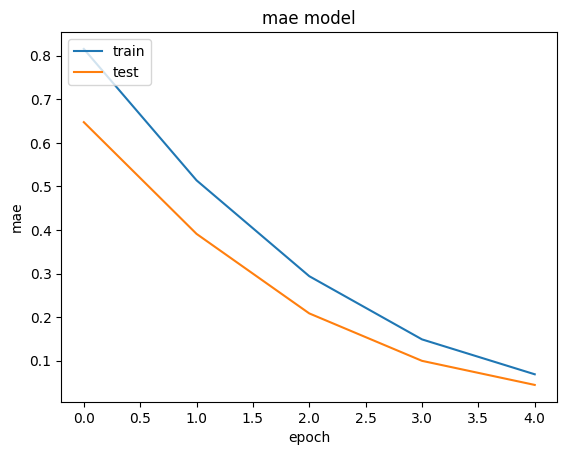

In [936]:
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.legend(['train', 'test'], loc='upper left')
plt.title('mae model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.show()

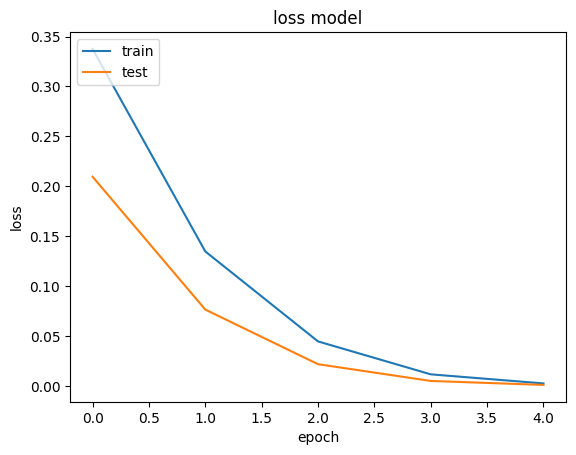

In [937]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')
plt.title('loss model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()